In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns; sns.set_style();
import pytorch_lightning as pl
from model.model_tf import ModelTF

In [2]:
# NOTE:
# sample_thanh: data/VNOnDB/word/train_word/20140603_0003_BCCTC_tg_0_0_3.png

In [3]:
device = 'cpu'
model = ModelTF.load_from_checkpoint('/home/aioz-intern-1/cnn_exp/tf_resnet34_2_lr1e-4/checkpoints/epoch=34.ckpt', map_location=device)
model.eval()

ModelTF(
  (loss_fn): CrossEntropyLoss()
  (cnn): ResnetFE(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): 

In [4]:
dataset=model.prepare_dataset('train', model.vocab, model.config, model.transform.test)
loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=1,
            shuffle=False,
            collate_fn=model.collate_fn,
            num_workers=model.config['num_workers'],
            pin_memory=True
        )

iter_loader = iter(loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


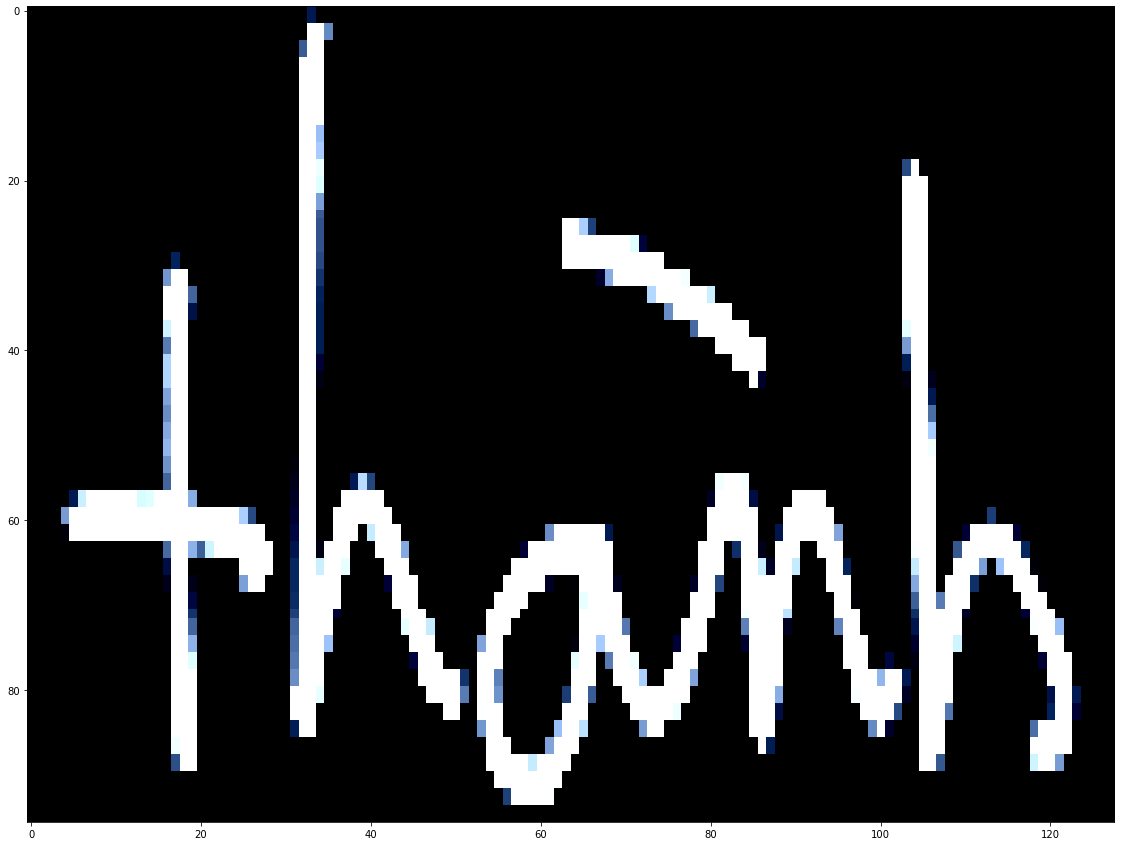

In [13]:
batch = next(iter_loader)

plt.figure(figsize=(20,15))
grid = torchvision.utils.make_grid(batch[0], nrow=8)
plt.imshow(grid.permute(1,2,0))

In [14]:
with torch.no_grad():
    for (output, length) in zip(batch[1].cpu().tolist(), batch[3].cpu().tolist()):
        output = list(map(model.vocab.int2char, output[:length]))
        output = model.vocab.process_label_invert(output)
        output = ' '.join(output)
        print(output)

<start> t h à n h <end>


In [15]:
with torch.no_grad():
    outputs, lengths, (enc_weights, enc_dec_weights, dec_weights) = model.decode(batch[0], 15, 1, output_weights=True)
    for (output, length) in zip(outputs.cpu().tolist(), lengths.cpu().tolist()):
        output = list(map(model.vocab.int2char, output[:length]))
        output = model.vocab.process_label_invert(output)
        output = ' '.join(output)
        print(output)

t h à n h <end>


In [16]:
def visualize_stn():
    if isinstance(model.stn, torch.nn.Identity):
        print('Model does not use STN')
        return
    stn = model.stn(inputs).detach()
    plt.figure(figsize=(20,15))
    stn = torchvision.utils.make_grid(stn, nrow=1)[0]
    plt.imshow(stn)
    plt.show()
visualize_stn()

Model does not use STN


torch.Size([1, 1, 6, 12, 16])


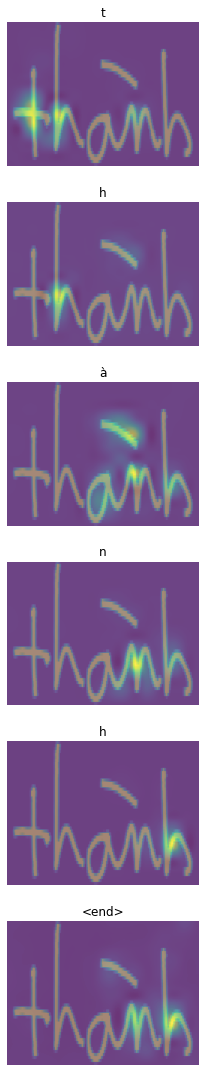

In [17]:
def visualize_enc_dec_weights(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,H,W]
    L, B, T, H, W = weights.shape
    alpha = 0.7
    fig, axes = plt.subplots(T, B, figsize=(20, 15), sharex=True, sharey=True, squeeze=False)

    weights = weights[layer_idx] # [B, T, H, W]

    for i, sample in enumerate(weights):
        # sample: [T, H, W]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
        for j, weight in enumerate(sample):
            # weight: [H, W]
            image_height, image_width = batch[0].shape[-2:]
            # weight = weight.transpose(-2, -1)
            weight = F.interpolate(weight.unsqueeze(0).unsqueeze(0), (image_height, image_width), mode='bicubic', align_corners=True) # 1,H,W
            weight = weight.squeeze(0).squeeze(0) # H,W
    
            input = batch[0][i, 0] # H,W

            axes[j, i].set_title(output[j])
            axes[j, i].axis('off')
            axes[j, i].imshow(weight, cmap='viridis', alpha=alpha)
            axes[j, i].imshow(input, cmap='viridis', alpha=(1-alpha))
            
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.25)
    plt.show()
    fig.savefig("misc/attn-enc-dec.png")
visualize_enc_dec_weights(enc_dec_weights[:, [0]]) # visualize first sample only

torch.Size([1, 1, 6, 6])
['<start>', 't', 'h', 'à', 'n', 'h']


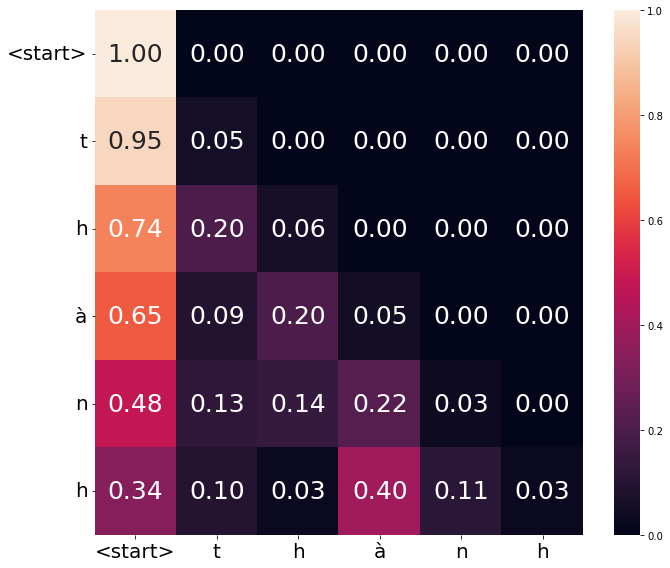

In [57]:
def visualize_dec_weights(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,T]
    L, B, T, T = weights.shape
    fig, axes = plt.subplots(B, 1, figsize=(10, 8), sharex=True, sharey=True, squeeze=False)

    weights = weights[layer_idx] # [B, T, T]

    for i, sample in enumerate(weights):
        # sample: [T, T]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
        output = [model.vocab.SOS] + output[:-1]
        print(output)
        sns.heatmap(sample, annot=True, fmt=".2f", annot_kws={"fontsize": 25}, ax=axes[i, 0])
        axes[i, 0].set_xticklabels(output, fontdict={'fontsize': 20})
        axes[i, 0].set_yticklabels(output, fontdict={'fontsize': 20, 'verticalalignment': 'center',
 'horizontalalignment': 'right'}, rotation='horizontal')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    fig.savefig("misc/attn-dec.png")
visualize_dec_weights(dec_weights[:, [0]]) # visualize first sample only